# Working demonstration

In [1]:
# Set up notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Run rompy

In [2]:
# Lets use an existing config file

!cat oceanum_datamesh_demo.yml

# Note that this is config demonstrates a full model 
# example running off the coast of Raglan. It uses
# era5 wind forcing, and spectral boundaries from
# oceanum's global hindcast. These datasets are 
# read from the oceanum catalog

run_id: oceanum 
period:
  start: 20230101T00
  duration: 6h
  interval: 1h
output_dir: simulations
config:
  model_type: swan
  grid:
    x0: 174.60
    y0: -37.95
    rot: 10.0
    dx: 0.02
    dy: 0.02
    nx: 20
    ny: 20
    gridtype: REG
  spectral_resolution:
    fmin: 0.0464
    fmax: 1.0
    nfreqs: 31
    ndirs: 36
  forcing:
    wind:
      model_type: swan
      id: wind 
      var: WIND 
      dataset: 
        model_type: datamesh
        dataset_id: era5_wind10m
        token: null # Use a Datamesh token here if not in your environment
      filter:
        sort: 
          coords: [latitude]
      z1: u10
      z2: v10
      latname: latitude
      lonname: longitude
    bottom: 
      id: bottom
      var: BOTTOM
      dataset: 
      

In [3]:
# This loading is awkward due to a pydantic issue - will be fixed

from rompy import ModelRun
from rompy.swan import SwanConfig
import yaml
import matplotlib.pyplot as plt
import xarray as xr
from cartopy import crs as ccrs
from wavespectra import read_swan

In [4]:
args = yaml.load(open('oceanum_datamesh_demo.yml', 'r'), Loader=yaml.FullLoader)
run = ModelRun(**args)

In [5]:
run.config.outputs.spec.locations

OutputLocs
  -37.96 174.61
  -37.96 174.62
  -37.97 174.62

(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: >)

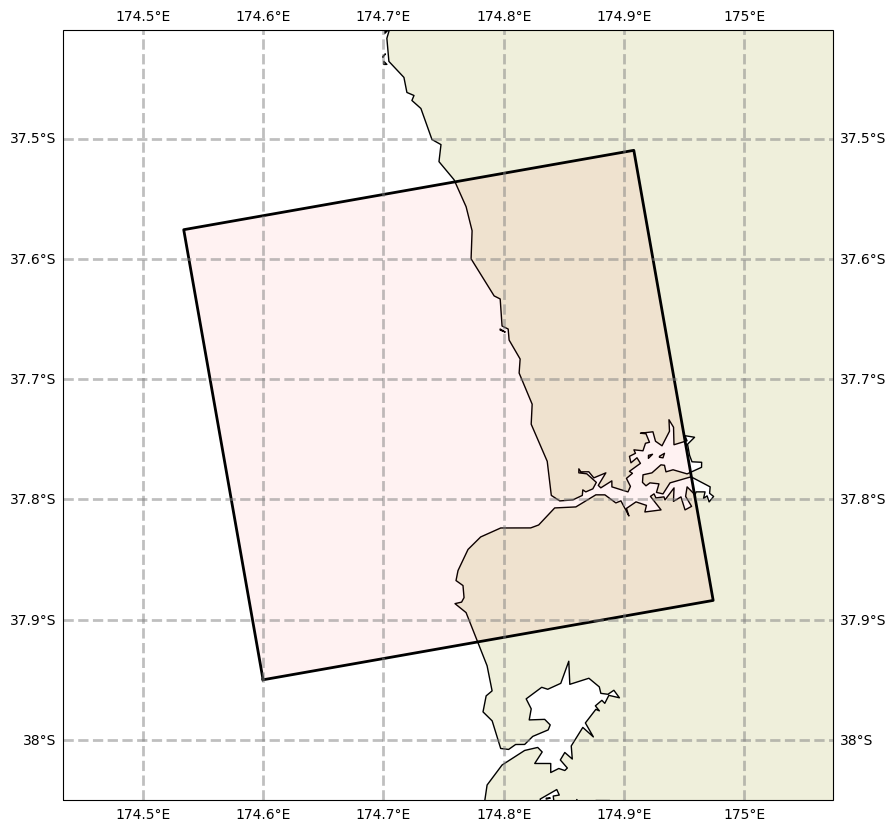

In [6]:
# Check the grid and spectral boundary points

boundary = run.config.forcing.boundary.ds.isel(time=0)

run.config.grid.plot()

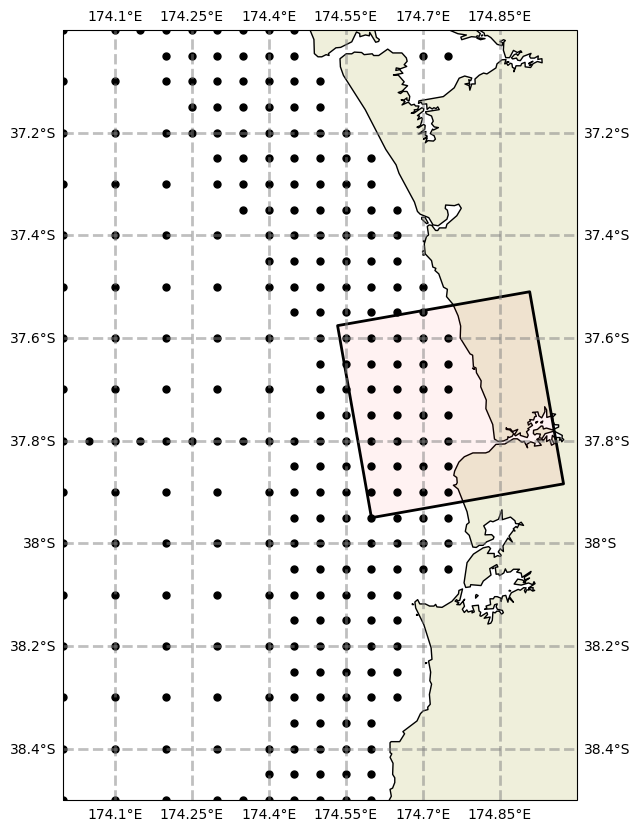

In [14]:
# Check the grid and spectral boundary points
xlim = (174, 175.0)
ylim = (-38.5, -37)

bnd_points = run.config.forcing.boundary.ds[["lat", "lon"]]
bnd_points = bnd_points.where(
    (
        (bnd_points.lon >= xlim[0]) &
        (bnd_points.lon <= xlim[1]) &
        (bnd_points.lat >= ylim[0]) &
        (bnd_points.lat <= ylim[1])
    )
)

fig, ax = run.config.grid.plot()
ax.plot(bnd_points.lon, bnd_points.lat, "ok", markersize=5, transform=ccrs.PlateCarree())
xlim = ax.set_xlim(xlim)
ylim = ax.set_ylim(ylim)

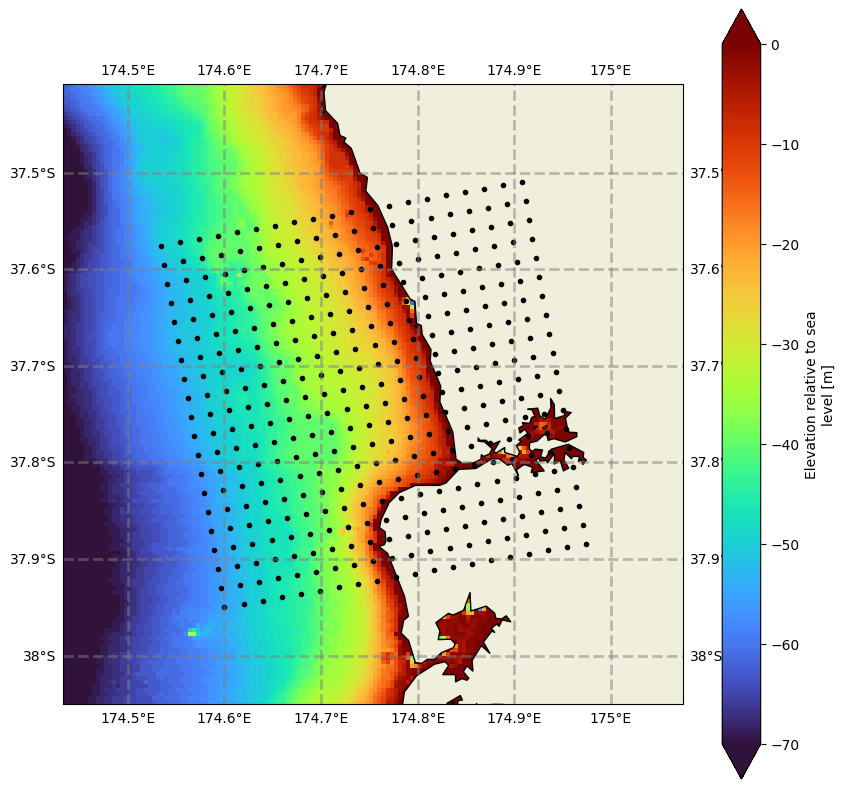

In [8]:
# Plot bottom grid to check

run.config.forcing.bottom._filter_grid(grid=run.config.grid)
fig, ax = run.config.forcing.bottom.plot(param='elevation', vmin=-70, vmax=0)
ax.plot(run.config.grid.x, run.config.grid.y, ".k");

In [9]:
run.config.forcing.wind.dataset

DatasetDatamesh(model_type='datamesh', dataset_id='era5_wind10m', token=None, kwargs={})

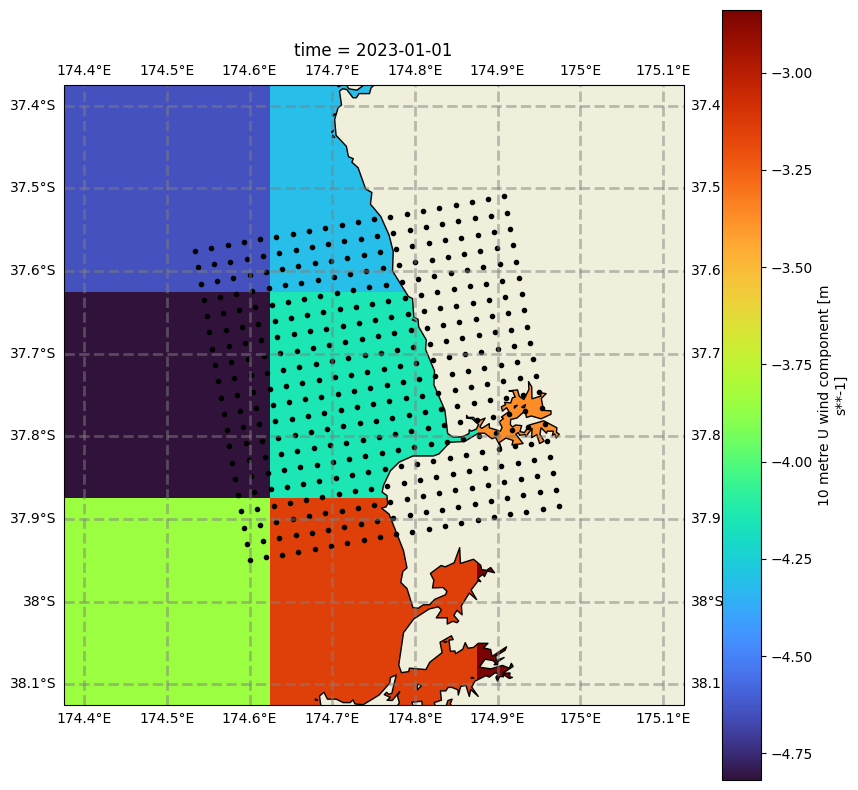

In [12]:
# Plot a single time step of the wind as a check
# (note that these next three lines are done internally within the wrapper, 
# we may want to write convenience methods for this)

run.config.forcing.wind._filter_grid(grid=run.config.grid)
run.config.forcing.wind._filter_time(time=run.period)

fig, ax = run.config.forcing.wind.plot(isel={'time': 0}, param='u10')
ax.plot(run.config.grid.x, run.config.grid.y, ".k", transform=ccrs.PlateCarree());

In [10]:
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
period: 

	Start: 2023-01-01 00:00:00
	End: 2023-01-01 06:00:00
	Duration: 6:00:00
	Interval: 1:00:00
	Include End: True


output_dir: 
simulations

config: 
grid: 
	SwanGrid: REG, 20x20
spectral_resolution: 
	fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: 
	bottom: DatasetIntake(catalog_uri=../rompy/catalogs/oceanum.yaml, dataset_id=gebco_2022)
	wind: DatasetIntake(catalog_uri=../rompy/catalogs/oceanum.yaml, dataset_id=era5_wind10m)
	boundary: DatasetIntake(catalog_uri=../rompy/catalogs/oceanum.yaml, dataset_id=oceanum_wave_nz_era5_v1_spec)

physics: 
	friction='MAD' friction_coeff=0.1
outputs: 
	Grid:
	variables: DEPTH UBOT HSIGN HSWELL DIR TPS TM01 WIND
	Spec
		locations:   -37.96 174.61
  -37.96 174.62
  -37.97 174.62


template: 
	/source/csiro/rompy/rompy/templates/swan

INFO:rompy.model:-----------------------------------------------------

'/source/csiro/rompy/notebooks/simulations/oceanum'

## Run SWAN

In [11]:
# Run the model

!docker run  -v ./simulations/oceanum:/home oceanum/swan:4141 swan.exe 


 SWAN is preparing computation

+SWAN is processing output request    1
+SWAN is processing output request    2
+time 20230101.001500   , step      1; iteration    1; sweep 1
+time 20230101.001500   , step      1; iteration    1; sweep 2
+time 20230101.001500   , step      1; iteration    1; sweep 3
+time 20230101.001500   , step      1; iteration    1; sweep 4
+time 20230101.001500   , step      1; iteration    2; sweep 1
+time 20230101.001500   , step      1; iteration    2; sweep 2
+time 20230101.001500   , step      1; iteration    2; sweep 3
+time 20230101.001500   , step      1; iteration    2; sweep 4
+time 20230101.001500   , step      1; iteration    3; sweep 1
+time 20230101.001500   , step      1; iteration    3; sweep 2
+time 20230101.001500   , step      1; iteration    3; sweep 3
+time 20230101.001500   , step      1; iteration    3; sweep 4
+time 20230101.001500   , step      1; iteration    4; sweep 1
+time 20230101.001500   , step      1; iteration    4; sweep 2
+time

## Plot outputs

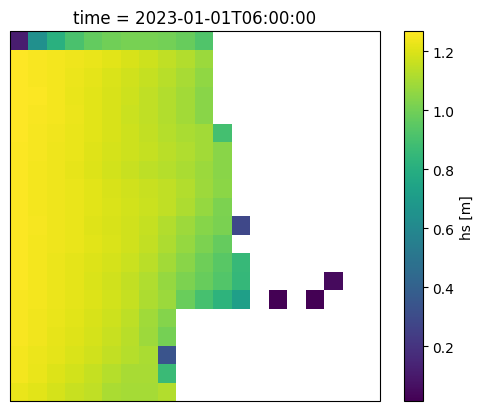

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
output = xr.open_dataset('simulations/oceanum/outputs/swan_out.nc')
output.hs.isel(time=-1).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

In [13]:
ll simulations/oceanum

total 1756
-rw-rw-r-- 1 rguedes 1577857 Jun 20 10:41 bnd.bnd
-rw-rw-r-- 1 rguedes  159874 Jun 20 10:37 bottom.grd
drwxrwxr-x 2 rguedes    4096 Jun 20 10:41 datasets/
-rw-rw-r-- 1 rguedes    1259 Jun 20 10:41 INPUT
-rw-r--r-- 1 root         25 Jun 20 10:41 norm_end
-rw-rw-r-- 1 rguedes     101 Jun 20 10:41 out.loc
drwxrwxr-x 2 rguedes    4096 Jun 20 10:41 outputs/
-rw-r--r-- 1 root      24194 Jun 20 10:41 PRINT
-rw-r--r-- 1 root        935 Jun 20 10:41 swaninit
-rw-rw-r-- 1 rguedes     837 Jun 20 10:40 wind.grd


In [14]:
output = xr.open_dataset('simulations/oceanum/outputs/swan_out.nc')
boundary = read_swan('simulations/oceanum/bnd.bnd')

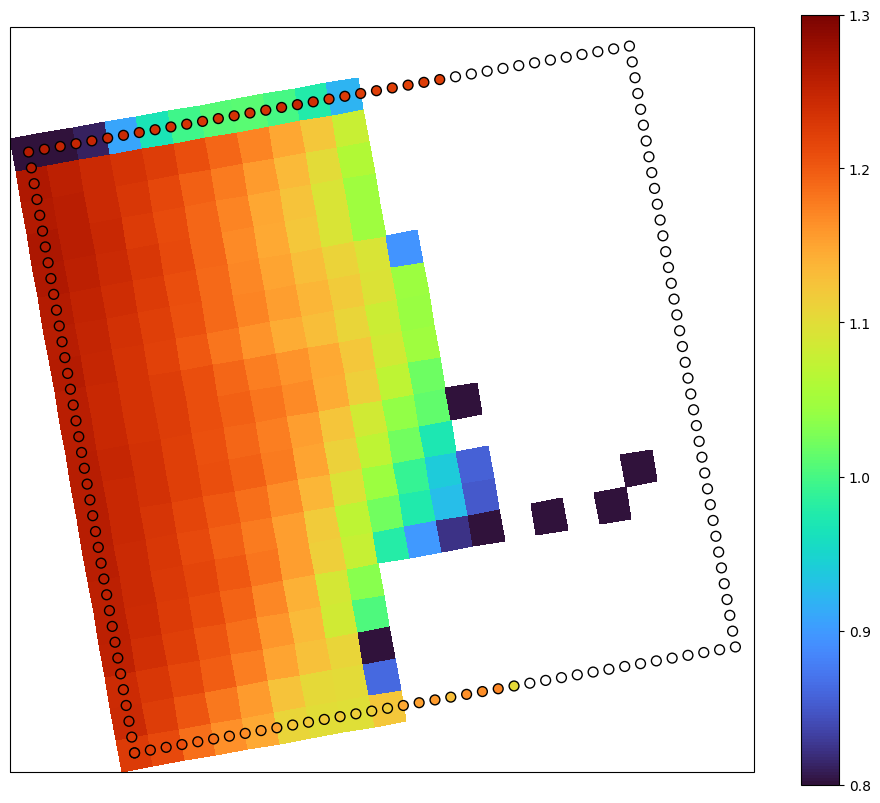

In [15]:
x = run.config.grid.x
y = run.config.grid.y
vmin = 0.8
vmax = 1.3

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ds = output.hs.isel(time=-1)
bnd = boundary.sel(time=ds.time).spec.hs()

p = ax.pcolormesh(x, y, ds, transform=ccrs.PlateCarree(), cmap="turbo", vmin=vmin, vmax=vmax)
ax.scatter(boundary.lon, boundary.lat, 50, c=bnd, cmap="turbo", vmin=vmin, vmax=vmax, edgecolor="k", transform=ccrs.PlateCarree())
plt.colorbar(p)

In [16]:
# Zip the run 
# run.zip()